In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns
from copy import deepcopy
%config InlineBackend.figure_format = 'retina'
import numpy as np
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests
from collections import Counter
from statsmodels.stats.multitest import multipletests
import sys
import warnings
from scipy.stats import spearmanr
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from statannot import add_stat_annotation

# Fungal cfu

In [19]:
#read sample info
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)

# read cfu data
df_fungi_cfu = pd.read_csv('tblcfu_fungi.txt', index_col=0)
df_fungi_cfu = df_fungi_cfu.groupby('Sample_ID').agg(np.mean)
df_fungi_cfu = df_fungi_cfu[df_fungi_cfu.culture.notnull()]
df_fungi_cfu = df_fungi_cfu.culture.astype(int).astype(str)
df_sample = pd.merge(df_sample, df_fungi_cfu, left_index=True, right_index=True, how='inner')

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab[set(df_blast_100.query_accver).intersection(df_relab.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_sample = pd.merge(df_sample, df_oral_total, how='inner', left_index=True, right_index=True)

ndata_negative = len(df_sample[df_sample.culture=='0'])
ndata_positive = len(df_sample[df_sample.culture=='1'])
print('negative data = %d, positive data = %d'%(ndata_negative, ndata_positive))

negative data = 989, positive data = 156


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Kruskal-Wallis paired samples, P_val=1.633e-02 stat=5.767e+00


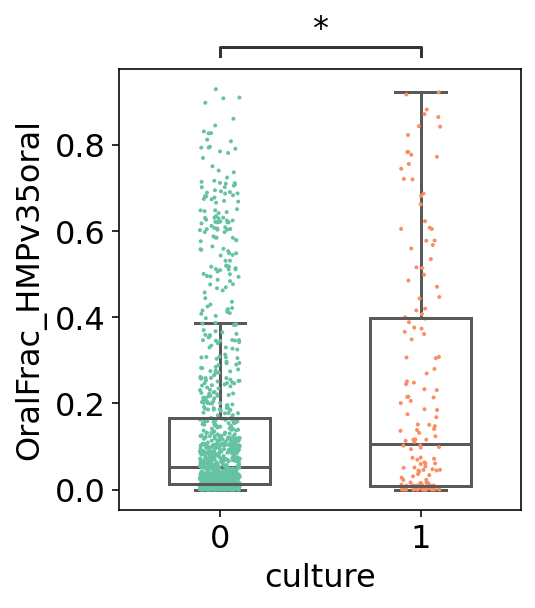

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4.5))
plt.rcParams.update({'font.size': 16})
_ = sns.stripplot(x='culture', y='OralFrac_HMPv35oral', data=df_sample, ax=ax, order=['0','1'], palette='Set2', jitter=0.1, s=2)
_ = sns.boxplot(x="culture", y="OralFrac_HMPv35oral", data=df_sample, saturation=1, showfliers=False, width=0.5, palette='Set2', boxprops={'zorder': 30, 'facecolor': 'none'}, ax=ax, order=['0','1'])
_ = add_stat_annotation(ax, data=df_sample, x='culture', y='OralFrac_HMPv35oral', order=['0','1'],
                        box_pairs=[('0','1')],
                        comparisons_correction=None,
                        test='Kruskal', text_format='star', loc='outside', verbose=1)
#_ = ax.plot([0,2],[-1.47,-1.47],'k--')
#_ = ax.plot([0,2],[-0.52,-0.52],'k--')
#_ = ax.set_ylim([-3.5,0.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("fungal_cfu_oral_correlation.svg")

# Stool consistency

In [12]:
#read sample info
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab[set(df_blast_100.query_accver).intersection(df_relab.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_sform = pd.merge(df_oral_total, df_sample, how='inner', left_index=True, right_index=True)
df_sform = df_sform[df_sform.Consistency.notnull()]

ndata_formed = len(df_sform[df_sform.Consistency=='formed'])
ndata_semi = len(df_sform[df_sform.Consistency=='semi-formed'])
ndata_liquid = len(df_sform[df_sform.Consistency=='liquid'])
print('formed stool # = %d, semi-formed stool # = %d, liquid stool # = %d'%(ndata_formed, ndata_semi, ndata_liquid))

formed stool # = 4156, semi-formed stool # = 4507, liquid stool # = 3569


In [21]:
df_sform.groupby('Consistency')['OralFrac_HMPv35oral'].agg(np.mean)

Consistency
formed         0.077098
liquid         0.154542
semi-formed    0.132762
Name: OralFrac_HMPv35oral, dtype: float64

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

formed v.s. semi-formed: Kruskal-Wallis paired samples, P_val=1.591e-31 stat=1.365e+02
semi-formed v.s. liquid: Kruskal-Wallis paired samples, P_val=2.037e-01 stat=1.616e+00
formed v.s. liquid: Kruskal-Wallis paired samples, P_val=2.887e-30 stat=1.307e+02


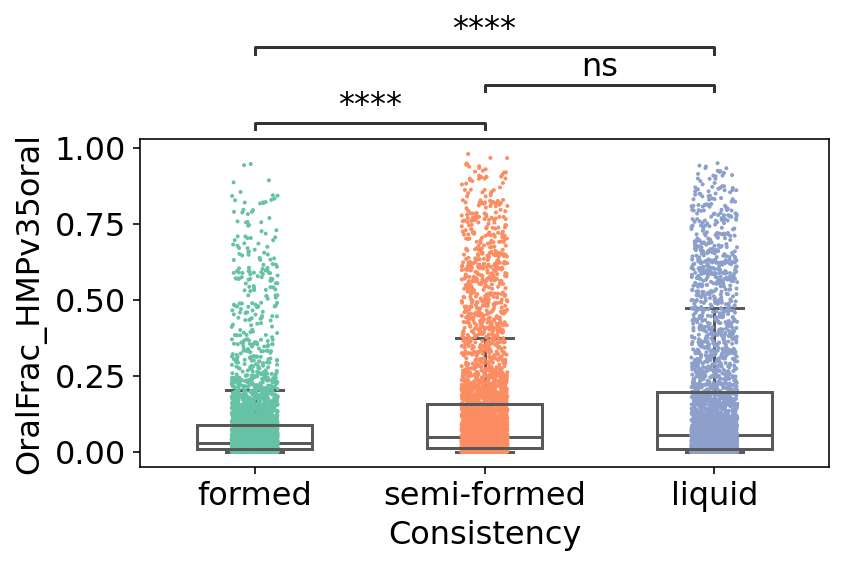

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
plt.rcParams.update({'font.size': 16})
_ = sns.stripplot(x='Consistency', y='OralFrac_HMPv35oral', data=df_sform, ax=ax, order=['formed','semi-formed','liquid'], palette='Set2', jitter=0.1, s=2)
_ = sns.boxplot(x="Consistency", y="OralFrac_HMPv35oral", data=df_sform, saturation=1, showfliers=False, width=0.5, palette='Set2', boxprops={'zorder': 30, 'facecolor': 'none'}, ax=ax, order=['formed','semi-formed','liquid'])
                
# use df2_sform for statistical test
_ = add_stat_annotation(ax, data=df_sform, x='Consistency', y='OralFrac_HMPv35oral', order=['formed','semi-formed','liquid'],
                        box_pairs=[("formed", "semi-formed"), ("formed", "liquid"), ("semi-formed", "liquid")],
                        comparisons_correction=None,
                        test='Kruskal', text_format='star', loc='outside', verbose=1)
#_ = ax.plot([0,2],[-1.47,-1.47],'k--')
#_ = ax.plot([0,2],[-0.52,-0.52],'k--')
#_ = ax.set_ylim([-3.5,0.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("stool_consistency_oral_correlation.svg")

# Association between oral ASV domination and Candida domination

In [33]:
# read sample info
df_sample = pd.read_csv('bacteria_fungi_database/tblsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read taxonomy
df_tax_bact = pd.read_csv("bacteria_fungi_database/tblASVtaxonomy_silva138_bact.csv", index_col=0)
df_tax_fungi = pd.read_csv("bacteria_fungi_database/tblASVtaxonomy_refseq_fungi_TR.csv", index_col=0)

# read count data
df_count = pd.read_csv('bacteria_fungi_database/tblcounts_melt_bact.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab_bact =  df_count.div(df_count.sum(axis=1), axis=0)

df_count = pd.read_csv('bacteria_fungi_database/tblcounts_melt_fungi.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab_fungi =  df_count.div(df_count.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab_bact.index))
df_sample = df_sample.loc[common_samples].reset_index()
df_relab_bact = df_relab_bact.loc[common_samples]

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
oral_ASVs = list(df_blast_100.query_accver)
df_oral = df_relab_bact[set(oral_ASVs).intersection(set(df_relab_bact.columns))].sum(axis=1)

# get candida taxa
candida_ASVs = list(set(df_tax_fungi[df_tax_fungi.Genus=='Candida'].index).intersection(df_relab_fungi.columns))

In [47]:
def build_cox_model_input_table(
    study_start_day = -10,
    study_stop_day = 40,
    domination_threshold=0.3,
    min_samples_per_patient = 2,
    memory_duration = 0 # this is effective only when indicator variable_reversibility is None
):
    
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue

        # check if the patient receives multiple HCT
        # treat each transplant as a new patient
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                assert first_sample_day < last_sample_day

            # find first domination of event ASVs (use timepoint to filter)
            df_relab_tmp = df_relab_fungi.loc[list(set(df_relab_fungi.index).intersection(set(df_sample_tmp.SampleID))), candida_ASVs]>0.9
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) == 0:
                # no domination by covar bacteria detected, set first domination day as the day of the last sample (censoring time)
                # as if the patient drop out at the day of last sample
                first_event_domination_day = last_sample_day
                domination_event = 0
            else:
                event_domination_days = list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])
                event_domination_days = [day for day in event_domination_days if day > first_sample_day]
                if len(event_domination_days) == 0:
                    first_event_domination_day = last_sample_day
                    domination_event = 0
                else:
                    first_event_domination_day = event_domination_days[0]
                    domination_event = 1
            assert first_event_domination_day > first_sample_day

            # find domination of genus of interest as a covariant
            df_relab_tmp = df_relab_bact.loc[list(df_sample_tmp.SampleID), set(oral_ASVs).intersection(set(df_relab_bact.columns))]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) >0:
                domination_days = [int(v) for v in list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])] # days that the genus of interest dominates the sample
                nondomination_days = list(set([int(v) for v in list(df_sample_tmp.DayRelativeToNearestHCT)])-set(domination_days))
                first_covar_domination_day = sorted(domination_days)[0]
                curr_state = 0
                if first_sample_day in domination_days:
                    prev_state = 1
                else:
                    prev_state = 0
                days_after_measurement = 0
                for day in np.arange(first_sample_day, first_event_domination_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive
                    is_dominated = int(right_day in domination_days)
                    not_dominated = int(right_day in nondomination_days)

                    # determine the current state
                    if is_dominated or not_dominated:
                        # sample was sequenced, either domination or non-domination
                        if is_dominated==1 and not_dominated==0:
                            curr_state = 1
                        elif is_dominated==0 and not_dominated==1:
                            curr_state = 0
                        else:
                            print('codes should not enter here!')
                            raise
                        days_after_measurement = 0 # reset the clock
                    else:
                        # sample was missing
                        # we only use memory to fill in missing values if previous state is dominated
                        # we assume memory is infinite if previous state is non-dominated
                        if prev_state==0:
                            curr_state=0
                        else:
                            if days_after_measurement>=memory_duration:
                                curr_state = 0
                            else:
                                curr_state = 1
                        days_after_measurement += 1

                    # add or merge a period
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.append(curr_state)
                        if right_day == first_event_domination_day:
                            curr_line.append(domination_event)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state)
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_event_domination_day:
                            last_line[-1] = domination_event
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line
            else:
                lines.append([pid, first_sample_day, first_event_domination_day, 0, domination_event])

    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay','CovarDomination','EventDomination'])
    return df_cox

In [48]:
# build input table
df_cox_wo_mem = build_cox_model_input_table(memory_duration=0, min_samples_per_patient=5)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
CovarDomination,8.50314,4.432105,16.313556,1.205359e-10


# Association between oral ASV domination and Enterococcus or Enterobacteriaceae or Proteobacteria ASV domination

In [85]:
# read sample info
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read taxonomy
df_tax = pd.read_csv("tblASVtaxonomy_silva138_v4v5_filter.csv", index_col=0)

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab.index))
df_sample = df_sample.loc[common_samples].reset_index()
df_relab = df_relab.loc[common_samples]

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
oral_ASVs = list(df_blast_100.query_accver)
df_oral = df_relab[set(oral_ASVs).intersection(set(df_relab.columns))].sum(axis=1)

In [218]:
# read drug administration records
df_drug = pd.read_csv('tbldrug.csv')
df_drug = df_drug[df_drug.AntiInfective==True].reset_index(drop=True)

# convert to single day entry
df_drug_single_day = []
for index in df_drug.index:
    start_tps = df_drug.loc[index,'StartTimepoint']
    stop_tps = df_drug.loc[index,'StopTimepoint']
    start_day = df_drug.loc[index,'StartDayRelativeToNearestHCT']
    for timepoint in np.arange(start_tps,stop_tps+1):
        res = list(df_drug.loc[index])
        res.append(timepoint)
        res.append(timepoint-start_tps+start_day)
        df_drug_single_day.append(res)
df_drug_single_day = pd.DataFrame(df_drug_single_day, columns=list(df_drug.columns)+['Timepoint','DayRelativeToNearestHCT'])
df_drug_single_day = df_drug_single_day.drop(['StartTimepoint','StopTimepoint','StartDayRelativeToNearestHCT','StopDayRelativeToNearestHCT'], axis=1)
df_drug = deepcopy(df_drug_single_day)
df_drug = df_drug[df_drug.DayRelativeToNearestHCT.notnull()]
df_drug = df_drug.drop_duplicates()

# only keep antibiotics
df_drug = df_drug[df_drug.Category.isin(['aminoglycosides','carbapenems','cephalosporins','glycopeptide antibiotics','glycylcyclines',
                                         'leprostatics','lincomycin derivatives','macrolide derivatives','miscellaneous antibiotics',
                                         'oxazolidinone antibiotics', 'penicillins','quinolones','sulfonamides','tetracyclines'])]

# restructure drugs for downstream analysis
df_drug['GroupLabel'] = 'other'

# change vancomycin to oral vanco and iv vanco
df_drug.loc[(df_drug.Factor=='vancomycin')&(df_drug.Route=='oral'), 'GroupLabel'] = 'vancomycin_oral'
df_drug.loc[(df_drug.Factor=='vancomycin')&(df_drug.Route=='intravenous'), 'GroupLabel'] = 'vancomycin_iv'

# change sulfamethoxazole trimethoprim to sulfamethoxazole/trimethoprim
df_drug.loc[df_drug.Factor=='sulfamethoxazole trimethoprim', 'Factor'] = 'sulfamethoxazole/trimethoprim'

# set the following factors as independent groups
for f in ['amoxicillin clavulanate','piperacillin/tazobactam','metronidazole','clindamycin',
          'tigecycline','linezolid','sulfamethoxazole/trimethoprim','doxycycline','aztreonam']:
    df_drug.loc[df_drug.Factor==f, 'GroupLabel'] = f
    
# set the following categories as independent groups
for c in ['carbapenems','aminoglycosides','cephalosporins','macrolide derivatives','quinolones']:
    df_drug.loc[df_drug.Category==c, 'GroupLabel'] = c

# select relevant columns
df_drug = df_drug[['PatientID','GroupLabel','DayRelativeToNearestHCT','Timepoint']]

# print unique drug groups
class2include = list(set(df_drug.GroupLabel))+['oral']

df_drug.head()

,PatientID,GroupLabel,DayRelativeToNearestHCT,Timepoint
0,1000,quinolones,-169,-160
2,1000,aztreonam,-160,-151
3,1000,vancomycin_iv,-160,-151
4,1000,aztreonam,-159,-150
6,1000,vancomycin_iv,-159,-150


In [228]:
def build_cox_model_input_table_v1(
    event_ASVs,
    study_start_day = -10,
    study_stop_day = 40,
    domination_threshold=0.3,
    min_samples_per_patient = 2,
    memory_duration = 0 # this is effective only when indicator variable_reversibility is None
):
    
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue

        # check if the patient receives multiple HCT
        # treat each transplant as a new patient
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                assert first_sample_day < last_sample_day

            # find first domination of event ASVs (use timepoint to filter)
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), event_ASVs]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) == 0:
                # no domination by covar bacteria detected, set first domination day as the day of the last sample (censoring time)
                # as if the patient drop out at the day of last sample
                first_event_domination_day = last_sample_day
                domination_event = 0
            else:
                event_domination_days = list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])
                event_domination_days = [day for day in event_domination_days if day > first_sample_day]
                if len(event_domination_days) == 0:
                    first_event_domination_day = last_sample_day
                    domination_event = 0
                else:
                    first_event_domination_day = event_domination_days[0]
                    domination_event = 1
            assert first_event_domination_day > first_sample_day

            # find domination of genus of interest as a covariant
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), set(oral_ASVs).intersection(set(df_relab.columns))]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) >0:
                domination_days = [int(v) for v in list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])] # days that the genus of interest dominates the sample
                nondomination_days = list(set([int(v) for v in list(df_sample_tmp.DayRelativeToNearestHCT)])-set(domination_days))
                first_covar_domination_day = sorted(domination_days)[0]
                curr_state = 0
                if first_sample_day in domination_days:
                    prev_state = 1
                else:
                    prev_state = 0
                days_after_measurement = 0
                for day in np.arange(first_sample_day, first_event_domination_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive
                    is_dominated = int(right_day in domination_days)
                    not_dominated = int(right_day in nondomination_days)

                    # determine the current state
                    if is_dominated or not_dominated:
                        # sample was sequenced, either domination or non-domination
                        if is_dominated==1 and not_dominated==0:
                            curr_state = 1
                        elif is_dominated==0 and not_dominated==1:
                            curr_state = 0
                        else:
                            print('codes should not enter here!')
                            raise
                        days_after_measurement = 0 # reset the clock
                    else:
                        # sample was missing
                        # we only use memory to fill in missing values if previous state is dominated
                        # we assume memory is infinite if previous state is non-dominated
                        if prev_state==0:
                            curr_state=0
                        else:
                            if days_after_measurement>=memory_duration:
                                curr_state = 0
                            else:
                                curr_state = 1
                        days_after_measurement += 1

                    # add or merge a period
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.append(curr_state)
                        if right_day == first_event_domination_day:
                            curr_line.append(domination_event)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state)
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_event_domination_day:
                            last_line[-1] = domination_event
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line
            else:
                lines.append([pid, first_sample_day, first_event_domination_day, 0, domination_event])

    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay','CovarDomination','EventDomination'])
    return df_cox

In [219]:
def build_cox_model_input_table_v2(
    event_ASVs,
    study_start_day = -10,
    study_stop_day = 40,
    domination_threshold=0.3,
    min_samples_per_patient = 2,
    min_abx_exposure_times=10,
    memory_duration = 0 # this is effective only when indicator variable_reversibility is None
):
    
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue

        # check if the patient receives multiple HCT
        # treat each transplant as a new patient
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                assert first_sample_day < last_sample_day

            # find first domination of event ASVs (use timepoint to filter)
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), event_ASVs]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) == 0:
                # no domination by covar bacteria detected, set first domination day as the day of the last sample (censoring time)
                # as if the patient drop out at the day of last sample
                first_event_domination_day = last_sample_day
                domination_event = 0
            else:
                event_domination_days = list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])
                event_domination_days = [day for day in event_domination_days if day > first_sample_day]
                if len(event_domination_days) == 0:
                    first_event_domination_day = last_sample_day
                    domination_event = 0
                else:
                    first_event_domination_day = event_domination_days[0]
                    domination_event = 1
            assert first_event_domination_day > first_sample_day

            # get drug exposure information
            curr_df_drug = df_drug[(df_drug.PatientID==pid) & (df_drug.Timepoint>tps_from) & (df_drug.Timepoint<=tps_to)]
            curr_df_drug = curr_df_drug[['DayRelativeToNearestHCT','GroupLabel']]
            
            # find oral domination and treat it as a drug variable
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), set(oral_ASVs).intersection(set(df_relab.columns))]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            df_oral_dominated_sample = df_sample_tmp[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index))]
            df_oral_dominated_sample['GroupLabel'] = 'oral'
            curr_df_drug = pd.concat([curr_df_drug, df_oral_dominated_sample[['DayRelativeToNearestHCT','GroupLabel']]], axis=0)
            if len(curr_df_drug) >0:

                # reformat drug record table, with each row a particular day and each column a drug
                curr_df_drug['Value'] = 1
                curr_df_drug = pd.pivot_table(curr_df_drug, index='DayRelativeToNearestHCT', columns='GroupLabel', values='Value').fillna(0)
                for drug in class2include:
                    if drug not in list(curr_df_drug.columns):
                        curr_df_drug[drug] = 0
                curr_df_drug = curr_df_drug[class2include].astype(int)

                # add covariates and event status for each period
                curr_state = [0] * len(class2include)
                # use drug exposure on the first sample day as the initial states
                if first_sample_day in list(curr_df_drug.index):
                    prev_state = list(curr_df_drug.loc[first_sample_day])
                else:
                    prev_state = [0] * len(class2include)
                days_after_measurement = [0] * len(class2include)
                for day in np.arange(first_sample_day, first_event_domination_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive

                    # get right day covariates
                    # drug_records are antibiotic exposure on the right day
                    if right_day in list(curr_df_drug.index):
                        drug_records = list(curr_df_drug.loc[right_day])
                    else:
                        drug_records = [0] * len(class2include)

                    # get current drug impact states
                    # since we consider antibiotic pharmacokinetics, antibiotic may impact microbiome over several days
                    curr_state = deepcopy(drug_records)
                    for k,r in enumerate(drug_records):
                        if drug_records[k]==1:
                            curr_state[k]=1
                            days_after_measurement[k] = 0 # reset the clock
                        else:
                            if days_after_measurement[k]>=memory_duration:
                                curr_state[k] = 0
                            else:
                                curr_state[k] = deepcopy(prev_state)[k]
                            days_after_measurement[k] += 1

                    # combine with previous records
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.extend(curr_state)
                        if right_day == first_event_domination_day:
                            curr_line.append(1)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state) # must be deepcopy! otherwise, change in curr_state will lead to the same change to prev_state
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_event_domination_day:
                            last_line[-1] = 1
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line                        
            else:
                lines.append([pid, first_sample_day, first_event_domination_day] + [0]*len(class2include) + [1])

    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay']+class2include+['EventDomination'])
    
    # remove drugs that have been used for less than 10 times
    drugs2drop = []
    for drug in df_cox.iloc[:,3:-2]:
        if np.sum(df_cox[drug]) < min_abx_exposure_times:
            drugs2drop.append(drug)
    df_cox = df_cox.drop(drugs2drop, axis=1)
    
    return df_cox

## Enterococcus genus

In [110]:
event_ASVs = list(df_tax[df_tax.Genus=='Enterococcus'].index)
selected_samples = list(df_sample[(df_sample.DayRelativeToNearestHCT>=-10) & (df_sample.DayRelativeToNearestHCT<=40)].SampleID)
((df_relab.loc[selected_samples, event_ASVs]>0.3).astype(int).sum(axis=1)>0).astype(int).sum()

1704

## v1

In [229]:
# build input table
event_ASVs = list(df_tax[df_tax.Genus=='Enterococcus'].index)
df_cox_wo_mem = build_cox_model_input_table_v1(memory_duration=0, min_samples_per_patient=5, event_ASVs=event_ASVs)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
CovarDomination,0.129245,0.032118,0.5201,0.003974


## v2

In [222]:
# build input table
event_ASVs = list(df_tax[df_tax.Genus=='Enterococcus'].index)
df_cox_wo_mem = build_cox_model_input_table_v2(memory_duration=0, min_samples_per_patient=5, event_ASVs=event_ASVs)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
quinolones,0.569119,0.352422,0.919061,0.021159
sulfamethoxazole/trimethoprim,0.588338,0.186178,1.859197,0.366213
carbapenems,0.656190,0.287056,1.500007,0.317915
piperacillin/tazobactam,0.669749,0.452748,0.990757,0.044809
vancomycin_iv,0.720506,0.483122,1.074530,0.107953
metronidazole,1.168398,0.584539,2.335437,0.659615
vancomycin_oral,1.194161,0.752037,1.896211,0.451989
aztreonam,1.247566,0.625214,2.489421,0.530311
other,1.379342,0.893317,2.129796,0.146784


## Enterobacteriaceae

In [115]:
event_ASVs = list(df_tax[df_tax.Family=='Enterobacteriaceae'].index)
selected_samples = list(df_sample[(df_sample.DayRelativeToNearestHCT>=-10) & (df_sample.DayRelativeToNearestHCT<=40)].SampleID)
((df_relab.loc[selected_samples, event_ASVs]>0.3).astype(int).sum(axis=1)>0).astype(int).sum()

304

## v1

In [230]:
# build input table
event_ASVs = list(df_tax[df_tax.Family=='Enterobacteriaceae'].index)
df_cox_wo_mem = build_cox_model_input_table_v1(memory_duration=0, min_samples_per_patient=5, event_ASVs=event_ASVs)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
CovarDomination,0.777518,0.245731,2.460147,0.668511


## v2

In [223]:
# build input table
event_ASVs = list(df_tax[df_tax.Family=='Enterobacteriaceae'].index)
df_cox_wo_mem = build_cox_model_input_table_v2(memory_duration=0, min_samples_per_patient=5, event_ASVs=event_ASVs)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
metronidazole,0.485591,0.175640,1.342510,1.638362e-01
aztreonam,0.562793,0.220409,1.437034,2.294097e-01
vancomycin_iv,0.632210,0.401576,0.995302,4.766983e-02
piperacillin/tazobactam,0.680719,0.447154,1.036284,7.285474e-02
linezolid,0.713360,0.244111,2.084636,5.370085e-01
carbapenems,0.847294,0.380916,1.884682,6.845606e-01
quinolones,0.854634,0.519314,1.406468,5.365621e-01
cephalosporins,0.896600,0.509996,1.576269,7.045728e-01
sulfamethoxazole/trimethoprim,1.035634,0.382318,2.805355,9.450966e-01


## Proteobacteria

In [116]:
event_ASVs = list(df_tax[df_tax.Phylum=='Proteobacteria'].index)
selected_samples = list(df_sample[(df_sample.DayRelativeToNearestHCT>=-10) & (df_sample.DayRelativeToNearestHCT<=40)].SampleID)
((df_relab.loc[selected_samples, event_ASVs]>0.3).astype(int).sum(axis=1)>0).astype(int).sum()

339

## v1

In [231]:
# build input table
event_ASVs = list(df_tax[df_tax.Phylum=='Proteobacteria'].index)
df_cox_wo_mem = build_cox_model_input_table_v1(memory_duration=0, min_samples_per_patient=5, event_ASVs=event_ASVs)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
CovarDomination,1.559928,0.724178,3.360186,0.256088


## v2

In [232]:
# build input table
event_ASVs = list(df_tax[df_tax.Phylum=='Proteobacteria'].index)
df_cox_wo_mem = build_cox_model_input_table_v2(memory_duration=0, min_samples_per_patient=5, event_ASVs=event_ASVs)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
metronidazole,0.683925,0.240224,1.947157,4.766692e-01
vancomycin_iv,0.708709,0.460541,1.090604,1.174445e-01
linezolid,0.715809,0.250349,2.046672,5.327830e-01
aztreonam,0.751363,0.333603,1.692269,4.901540e-01
quinolones,0.774956,0.474281,1.266246,3.088259e-01
carbapenems,0.790319,0.343209,1.819895,5.802961e-01
cephalosporins,0.834877,0.468786,1.486861,5.399559e-01
piperacillin/tazobactam,0.889426,0.605026,1.307512,5.511328e-01
vancomycin_oral,0.994806,0.621187,1.593143,9.827094e-01


# Association between oral bacteria and engraftment

In [173]:
# read sample info
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read patient info
# only work on patients with known engrafatment day
df_hct = pd.read_csv('tblhctmeta.csv')
df_hct = df_hct[df_hct.EngraftmentDayRelativeToNearestHCT.notnull()]

# read taxonomy
df_tax = pd.read_csv("tblASVtaxonomy_silva138_v4v5_filter.csv", index_col=0)

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab.index))
df_sample = df_sample.loc[common_samples].reset_index()
df_relab = df_relab.loc[common_samples]

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
oral_ASVs = list(df_blast_100.query_accver)
df_oral = df_relab[set(oral_ASVs).intersection(set(df_relab.columns))].sum(axis=1)

In [235]:
# read drug administration records
df_drug = pd.read_csv('tbldrug.csv')
df_drug = df_drug[df_drug.Factor.isin(['filgrastim','mycophenolate mofetil','cetirizine'])]

# convert to single day entry
df_drug_single_day = []
for index in df_drug.index:
    start_tps = df_drug.loc[index,'StartTimepoint']
    stop_tps = df_drug.loc[index,'StopTimepoint']
    start_day = df_drug.loc[index,'StartDayRelativeToNearestHCT']
    for timepoint in np.arange(start_tps,stop_tps+1):
        res = list(df_drug.loc[index])
        res.append(timepoint)
        res.append(timepoint-start_tps+start_day)
        df_drug_single_day.append(res)
df_drug_single_day = pd.DataFrame(df_drug_single_day, columns=list(df_drug.columns)+['Timepoint','DayRelativeToNearestHCT'])
df_drug_single_day = df_drug_single_day.drop(['StartTimepoint','StopTimepoint','StartDayRelativeToNearestHCT','StopDayRelativeToNearestHCT'], axis=1)
df_drug = deepcopy(df_drug_single_day)
df_drug = df_drug[df_drug.DayRelativeToNearestHCT.notnull()]
df_drug.PatientID = df_drug.PatientID.astype(str)
df_drug.head()

,PatientID,Factor,Category,AntiInfective,Route,Timepoint,DayRelativeToNearestHCT
0,1000,filgrastim,immunostimulants,False,injection,-141,-150
1,1000,filgrastim,immunostimulants,False,injection,16,7
2,1000,filgrastim,immunostimulants,False,injection,17,8
3,1000,filgrastim,immunostimulants,False,injection,18,9
4,1000,filgrastim,immunostimulants,False,injection,19,10


In [266]:
len(set(df_drug.PatientID))

1278

In [268]:
len(set(df_drug[df_drug.Factor=="filgrastim"].PatientID))

1277

In [269]:
len(set(df_drug[df_drug.Factor=="mycophenolate mofetil"].PatientID))

459

In [270]:
len(set(df_drug[df_drug.Factor=="cetirizine"].PatientID))

139

array([[<AxesSubplot:title={'center':'DayRelativeToNearestHCT'}>]],
      dtype=object)

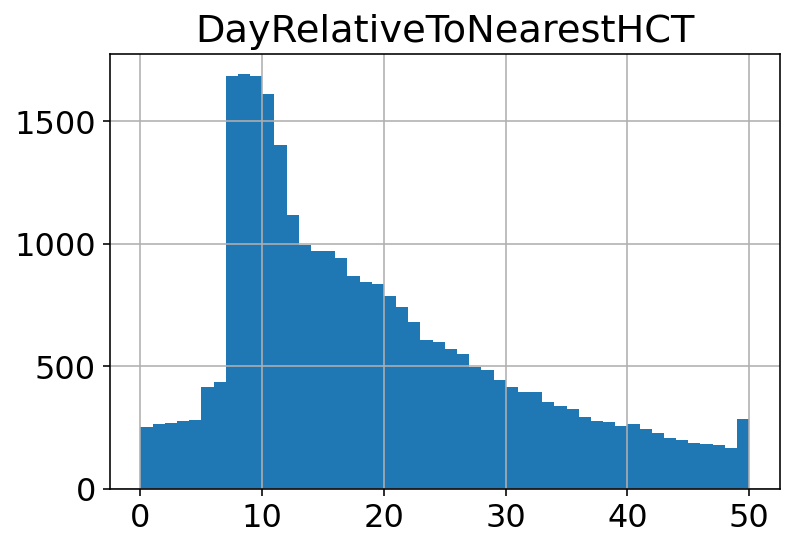

In [275]:
df_drug.loc[(df_drug.DayRelativeToNearestHCT>=0) & (df_drug.DayRelativeToNearestHCT<=50),['DayRelativeToNearestHCT']].hist(bins=50)

In [236]:
set(df_drug.Factor)

{'cetirizine', 'filgrastim', 'mycophenolate mofetil'}

In [237]:
class2include = ['cetirizine', 'filgrastim', 'mycophenolate mofetil', 'oral']

In [238]:
def build_cox_model_input_table(
    study_start_day = -10,
    study_stop_day = 40,
    domination_threshold=0.3,
    min_samples_per_patient = 2,
    memory_duration = 0 # this is effective only when indicator variable_reversibility is None
):
    
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue

        # check if the patient receives multiple HCT
        # treat each transplant as a new patient
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            # make sure engraftment
            df_hct_tmp = df_hct[(df_hct.PatientID==pid) & (df_hct.TimepointOfTransplant>tps_from) & (df_hct.TimepointOfTransplant<=tps_to)]
            if len(df_hct_tmp)>1:
                if pid=='297':
                    continue
                else:
                    print(tps_from, tps_to)
                    print(df_hct_tmp)
                    assert len(df_hct_tmp)<=1
            elif len(df_hct_tmp)==0:
                continue
            else:
                engraftment_day = list(df_hct_tmp.EngraftmentDayRelativeToNearestHCT)[0]
            
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                assert first_sample_day < last_sample_day
                
            # get drug exposure information
            curr_df_drug = df_drug[(df_drug.PatientID==pid) & (df_drug.Timepoint>tps_from) & (df_drug.Timepoint<=tps_to)]
            curr_df_drug = curr_df_drug[['DayRelativeToNearestHCT','Factor']]
            
            # find oral domination and treat it as a drug variable
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), set(oral_ASVs).intersection(set(df_relab.columns))]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            df_oral_dominated_sample = df_sample_tmp[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index))]
            df_oral_dominated_sample['Factor'] = 'oral'
            curr_df_drug = pd.concat([curr_df_drug, df_oral_dominated_sample[['DayRelativeToNearestHCT','Factor']]], axis=0)
            if len(curr_df_drug) >0:

                # reformat drug record table, with each row a particular day and each column a drug
                curr_df_drug['Value'] = 1
                curr_df_drug = pd.pivot_table(curr_df_drug, index='DayRelativeToNearestHCT', columns='Factor', values='Value').fillna(0)
                for drug in class2include:
                    if drug not in list(curr_df_drug.columns):
                        curr_df_drug[drug] = 0
                curr_df_drug = curr_df_drug[class2include].astype(int)

                # add covariates and event status for each period
                curr_state = [0] * len(class2include)
                # use drug exposure on the first sample day as the initial states
                if first_sample_day in list(curr_df_drug.index):
                    prev_state = list(curr_df_drug.loc[first_sample_day])
                else:
                    prev_state = [0] * len(class2include)
                days_after_measurement = [0] * len(class2include)
                for day in np.arange(first_sample_day, engraftment_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive

                    # get right day covariates
                    # drug_records are antibiotic exposure on the right day
                    if right_day in list(curr_df_drug.index):
                        drug_records = list(curr_df_drug.loc[right_day])
                    else:
                        drug_records = [0] * len(class2include)

                    # get current drug impact states
                    # since we consider antibiotic pharmacokinetics, antibiotic may impact microbiome over several days
                    curr_state = deepcopy(drug_records)
                    for k,r in enumerate(drug_records):
                        if drug_records[k]==1:
                            curr_state[k]=1
                            days_after_measurement[k] = 0 # reset the clock
                        else:
                            if days_after_measurement[k]>=memory_duration:
                                curr_state[k] = 0
                            else:
                                curr_state[k] = deepcopy(prev_state)[k]
                            days_after_measurement[k] += 1

                    # combine with previous records
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.extend(curr_state)
                        if right_day == engraftment_day:
                            curr_line.append(1)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state) # must be deepcopy! otherwise, change in curr_state will lead to the same change to prev_state
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == engraftment_day:
                            last_line[-1] = 1
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line                        
            else:
                lines.append([pid, first_sample_day, engraftment_day] + [0]*len(class2include) + [1])

    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay']+class2include+['Engraftment'])
    return df_cox

In [239]:
# build input table
df_cox_wo_mem = build_cox_model_input_table(memory_duration=0, min_samples_per_patient=5)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="EventDomination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
mycophenolate mofetil,0.321743,0.260515,0.397362,6.353634e-26
filgrastim,0.447770,0.354689,0.565279,1.403252e-11
cetirizine,0.948515,0.583228,1.542588,8.313045e-01
oral,1.644884,1.184592,2.284031,2.964788e-03


# Association between oral bacteria and white blood cells

In [277]:
# read sample info
df_sample = pd.read_csv('tblASVsamples.csv')
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.SampleID).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab[set(df_blast_100.query_accver).intersection(df_relab.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_relab = pd.concat([df_relab, df_oral_total], axis=1)

# read engraftment table
df_hct = pd.read_csv('tblhctmeta.csv', index_col=0)
df_hct = df_hct[(df_hct.EngraftmentDayRelativeToNearestHCT.notnull()) & (df_hct.TimepointOfTransplant.notnull())]
df_hct = df_hct[['TimepointOfTransplant','EngraftmentDayRelativeToNearestHCT','HCTSource']]
df_sample = df_sample[df_sample.PatientID.isin(list(df_hct.index))]

# read white blood cell
df_bc = pd.read_csv('tblbc.csv')
df_bc.PatientID = df_bc.PatientID.astype(str)

In [158]:
for t in ['WBCtotal','Neutrophils','Lymphocytes','Monocytes']:
    df_tmp = df_bc[(df_bc.BloodCellType==t) & (df_bc.Value>0)]
    print('minimum count of %s = %2.2f'%(t, np.min(df_tmp.Value)))

minimum count of WBCtotal = 0.05
minimum count of Neutrophils = 0.02
minimum count of Lymphocytes = 0.01
minimum count of Monocytes = 0.01


In [159]:
set(df_bc.BloodCellType)

{'BandCells',
 'Basophils',
 'BlastCells',
 'Eosinophils',
 'ImmatureGranulocytes',
 'ImmatureMonocytes',
 'Lymphocytes',
 'Monocytes',
 'Neutrophils',
 'Platelets',
 'RBCtotal',
 'SezaryCells',
 'VariantLymphocytes',
 'WBCtotal'}

In [160]:
set(df_hct.HCTSource)

{'BM_unmodified', 'PBSC_unmodified', 'TCD', 'cord'}

In [161]:
[df_hct.EngraftmentDayRelativeToNearestHCT.min(),df_hct.EngraftmentDayRelativeToNearestHCT.max()]

[7.0, 46.0]

In [162]:
# read drug administration records
df_drug = pd.read_csv('tbldrug.csv')
df_drug = df_drug[df_drug.Factor.isin(['filgrastim','mycophenolate mofetil','cetirizine'])]

# convert to single day entry
df_drug_single_day = []
for index in df_drug.index:
    start_tps = df_drug.loc[index,'StartTimepoint']
    stop_tps = df_drug.loc[index,'StopTimepoint']
    start_day = df_drug.loc[index,'StartDayRelativeToNearestHCT']
    for timepoint in np.arange(start_tps,stop_tps+1):
        res = list(df_drug.loc[index])
        res.append(timepoint)
        res.append(timepoint-start_tps+start_day)
        df_drug_single_day.append(res)
df_drug_single_day = pd.DataFrame(df_drug_single_day, columns=list(df_drug.columns)+['Timepoint','DayRelativeToNearestHCT'])
df_drug_single_day = df_drug_single_day.drop(['StartTimepoint','StopTimepoint','StartDayRelativeToNearestHCT','StopDayRelativeToNearestHCT'], axis=1)
df_drug = deepcopy(df_drug_single_day)
df_drug = df_drug[df_drug.DayRelativeToNearestHCT.notnull()]
df_drug.PatientID = df_drug.PatientID.astype(str)
df_drug.head()

,PatientID,Factor,Category,AntiInfective,Route,Timepoint,DayRelativeToNearestHCT
0,1000,filgrastim,immunostimulants,False,injection,-141,-150
1,1000,filgrastim,immunostimulants,False,injection,16,7
2,1000,filgrastim,immunostimulants,False,injection,17,8
3,1000,filgrastim,immunostimulants,False,injection,18,9
4,1000,filgrastim,immunostimulants,False,injection,19,10


In [328]:
lines = []
max_day_after_eng = 100
for k,pid in enumerate(df_hct.index):
    # transplant type
    curr_ttype = df_hct.iloc[k]['HCTSource']
                
    # engraftment time point
    eng_tps = df_hct.iloc[k]['EngraftmentDayRelativeToNearestHCT']+df_hct.iloc[k]['TimepointOfTransplant']
    
    # find paired samples and wbc data
    df_sample_tmp = df_sample[(df_sample.PatientID==pid) & (df_sample.Timepoint>=eng_tps) & (df_sample.Timepoint<=max_day_after_eng+eng_tps)]
    df_bc_tmp = df_bc[(df_bc.PatientID==pid) & (df_bc.Timepoint>=eng_tps) & (df_bc.Timepoint<=max_day_after_eng+eng_tps) & (df_bc.BloodCellType.isin(['WBCtotal','Neutrophils','Lymphocytes','Monocytes']))]
    df_drug_tmp = df_drug[(df_drug.PatientID==pid) & (df_drug.Timepoint>=eng_tps) & (df_drug.Timepoint<=max_day_after_eng+eng_tps)]
    
    # check if wbc data is available for given sample
    for sid,tps in zip(df_sample_tmp.SampleID, df_sample_tmp.Timepoint):
        if tps in list(df_bc_tmp.Timepoint) and tps+1 in list(df_bc_tmp.Timepoint):
            if sid not in set(df_relab.index):
                continue
            all_data_exist=True
            for t in ['WBCtotal','Neutrophils','Lymphocytes','Monocytes']:
                if len(df_bc_tmp.loc[(df_bc_tmp.Timepoint==tps) & (df_bc_tmp.BloodCellType==t)])==0:
                    all_data_exist=False
                    break
                if len(df_bc_tmp.loc[(df_bc_tmp.Timepoint==tps+1) & (df_bc_tmp.BloodCellType==t)])==0:
                    all_data_exist=False
                    break
            if all_data_exist==False:
                continue
            oral_abundance = df_relab.loc[sid, 'OralFrac_HMPv35oral']
            is_oral_dom = (df_relab.loc[sid, set(oral_ASVs).intersection(set(df_relab.columns))]>0.3).astype(int).sum()>0
            curr_arr = [pid, curr_ttype, oral_abundance, is_oral_dom]
            for t in ['WBCtotal','Neutrophils','Lymphocytes','Monocytes']:    
                try:
                    wbc1 = list(df_bc_tmp.loc[(df_bc_tmp.Timepoint==tps+1) & (df_bc_tmp.BloodCellType==t),'Value'])[0]
                    wbc0 = list(df_bc_tmp.loc[(df_bc_tmp.Timepoint==tps) & (df_bc_tmp.BloodCellType==t),'Value'])[0]
                    if wbc1<0.005:
                        if t=='WBCtotal':
                            wbc1 = 0.05
                        if t=='Neutrophils':
                            wbc1 = 0.02
                        if t=='Lymphocytes' or t=='Monocytes':
                            wbc1 = 0.01
                    if wbc0<0.005:
                        if t=='WBCtotal':
                            wbc0 = 0.05
                        if t=='Neutrophils':
                            wbc0 = 0.02
                        if t=='Lymphocytes' or t=='Monocytes':
                            wbc0 = 0.01
                    dlogW = np.log(wbc1)-np.log(wbc0)
                    curr_arr.append(dlogW)
                    curr_arr.append(np.sqrt(wbc0*wbc1))
                except:
                    assert 0
            for drug in ['filgrastim','mycophenolate mofetil','cetirizine']:
                df_drug_tmp2 = df_drug_tmp[df_drug_tmp.Factor==drug]
                if tps in list(df_drug_tmp2.Timepoint):# or tps+1 in list(df_drug_tmp2.Timepoint):
                    curr_arr.append(1)
                else:
                    curr_arr.append(0)
            lines.append(curr_arr)
    
df_data = pd.DataFrame(lines, columns=['PatientID','TransplantType','OralAbundance','Is_oral_domination',
                                       'dlogW_WBCtotal','gMean_WBCtotal','dlogW_Neutrophils','gMean_Neutrophils','dlogW_Lymphocytes','gMean_Lymphocytes','dlogW_Monocytes','gMean_Monocytes',
                                       'filgrastim','mm','cetirizine'])
df_data.drop(['Is_oral_domination'], axis=1).to_csv('logistic_regression_wbc_table_100.csv', index=False)
df_data['Is_oral_domination'] = df_data['Is_oral_domination'].astype(int).astype(str)
df_data.head()

,PatientID,TransplantType,OralAbundance,Is_oral_domination,dlogW_WBCtotal,gMean_WBCtotal,dlogW_Neutrophils,gMean_Neutrophils,dlogW_Lymphocytes,gMean_Lymphocytes,dlogW_Monocytes,gMean_Monocytes,filgrastim,mm,cetirizine
0,FMT.0161,TCD,0.042375,0,0.809107,9.141663,0.931558,6.213695,2.302585,0.031623,0.747214,1.307670,0,0,0
1,FMT.0161,TCD,0.045805,0,0.148923,14.759065,0.158470,10.716343,0.693147,0.141421,0.000000,1.900000,0,0,0
2,FMT.0161,TCD,0.102031,0,-0.232622,14.154151,-0.409785,9.450926,-2.995732,0.044721,0.191055,2.090454,0,0,0
3,FMT.0161,TCD,0.046742,0,-0.392042,6.082763,0.031749,3.149603,-2.995732,0.044721,-0.479573,1.652271,0,0,0
4,FMT.0161,TCD,0.005400,0,-0.353640,3.938274,-0.567984,2.258318,0.000000,0.100000,-0.336472,1.183216,0,0,0


In [346]:
set(df_data.TransplantType)

{'BM_unmodified', 'PBSC_unmodified', 'TCD', 'cord'}

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Kruskal-Wallis paired samples, P_val=4.146e-01 stat=6.656e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Kruskal-Wallis paired samples, P_val=2.481e-01 stat=1.334e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Kruskal-Wallis paired samples, P_val=1.286e-09 stat=3.683e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0 v.s. 1: Kruskal-Wallis paired samples, P_val=1.633e-02 stat=5.766e+00


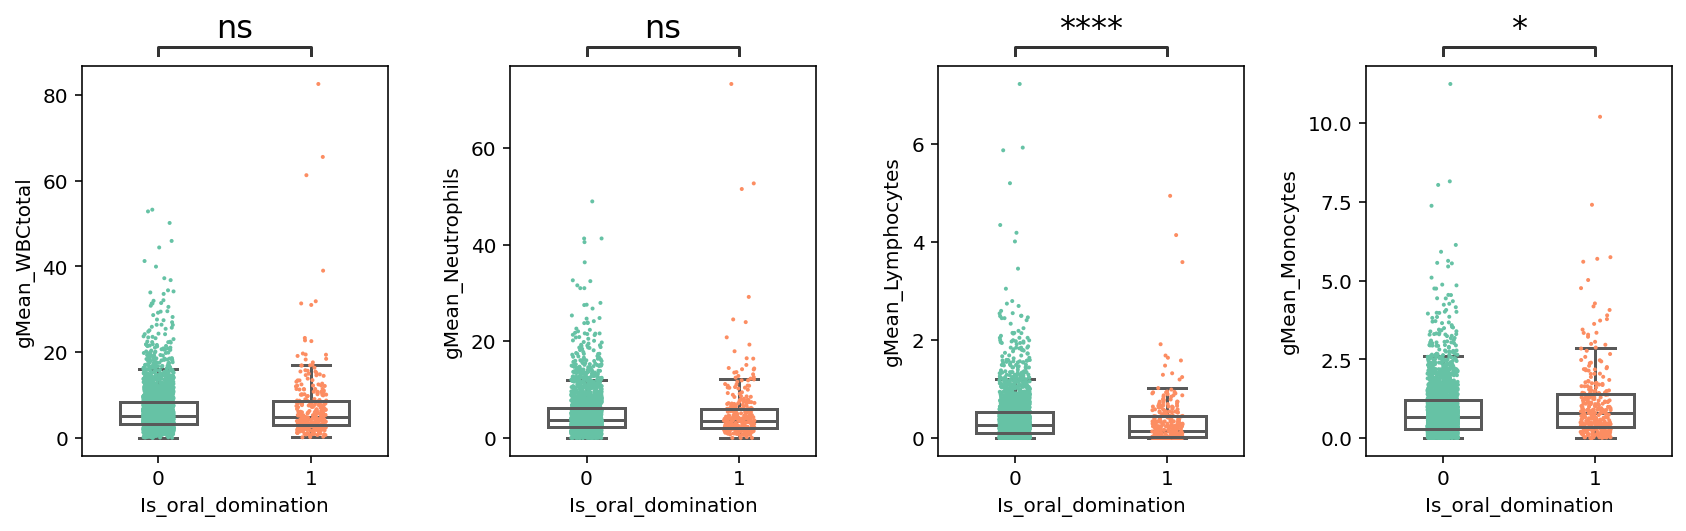

In [329]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
plt.rcParams.update({'font.size': 16})

for k,var in enumerate(['gMean_WBCtotal','gMean_Neutrophils','gMean_Lymphocytes','gMean_Monocytes']):
    _ = sns.stripplot(x='Is_oral_domination', y=var, data=df_data, ax=ax[k], palette='Set2', jitter=0.1, s=2, order=['0','1'])
    _ = sns.boxplot(x="Is_oral_domination", y=var, data=df_data, saturation=1, showfliers=False, width=0.5, palette='Set2', boxprops={'zorder': 30, 'facecolor': 'none'}, ax=ax[k], order=['0','1'])
    _ = add_stat_annotation(ax[k], data=df_data, x='Is_oral_domination', y=var, order=['0','1'],
                            box_pairs=[('0','1')],
                            comparisons_correction=None,
                            test='Kruskal', text_format='star', loc='outside', verbose=1)
#_ = ax.plot([0,2],[-1.47,-1.47],'k--')
#_ = ax.plot([0,2],[-0.52,-0.52],'k--')
#_ = ax.set_ylim([-3.5,0.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("association_oral_domination_immunity.svg")

## association with oral domination

In [330]:
df_data.groupby('Is_oral_domination')[['gMean_WBCtotal','gMean_Neutrophils','gMean_Monocytes','gMean_Lymphocytes']].agg(np.median)

,gMean_WBCtotal,gMean_Neutrophils,gMean_Monocytes,gMean_Lymphocytes
Is_oral_domination,,,,
0,5.242613,3.666061,0.670820,0.282843
1,4.904080,3.521363,0.806226,0.141421


In [331]:
df_data.groupby('Is_oral_domination')[['gMean_WBCtotal','gMean_Neutrophils','gMean_Monocytes','gMean_Lymphocytes']].agg(np.mean)

,gMean_WBCtotal,gMean_Neutrophils,gMean_Monocytes,gMean_Lymphocytes
Is_oral_domination,,,,
0,6.741844,4.975369,0.898498,0.414420
1,7.305386,5.337316,1.117047,0.321388


## association with oral abundance

In [332]:
df2_data = df_data[df_data.gMean_WBCtotal.notnull()]
spearmanr(df2_data.gMean_WBCtotal, df2_data.OralAbundance)

SpearmanrResult(correlation=-0.052214627619846715, pvalue=0.005760366962492555)

In [333]:
df2_data = df_data[df_data.gMean_Neutrophils.notnull()]
spearmanr(df2_data.gMean_Neutrophils, df2_data.OralAbundance)

SpearmanrResult(correlation=-0.04690480258553822, pvalue=0.013137960342102307)

In [334]:
df2_data = df_data[df_data.gMean_Lymphocytes.notnull()]
spearmanr(df2_data.gMean_Lymphocytes, df2_data.OralAbundance)

SpearmanrResult(correlation=-0.06990047966115748, pvalue=0.00021700305820037357)

In [335]:
df2_data = df_data[df_data.gMean_Monocytes.notnull()]
spearmanr(df2_data.gMean_Monocytes, df2_data.OralAbundance)

SpearmanrResult(correlation=-0.016609206465148303, pvalue=0.38007436177690757)

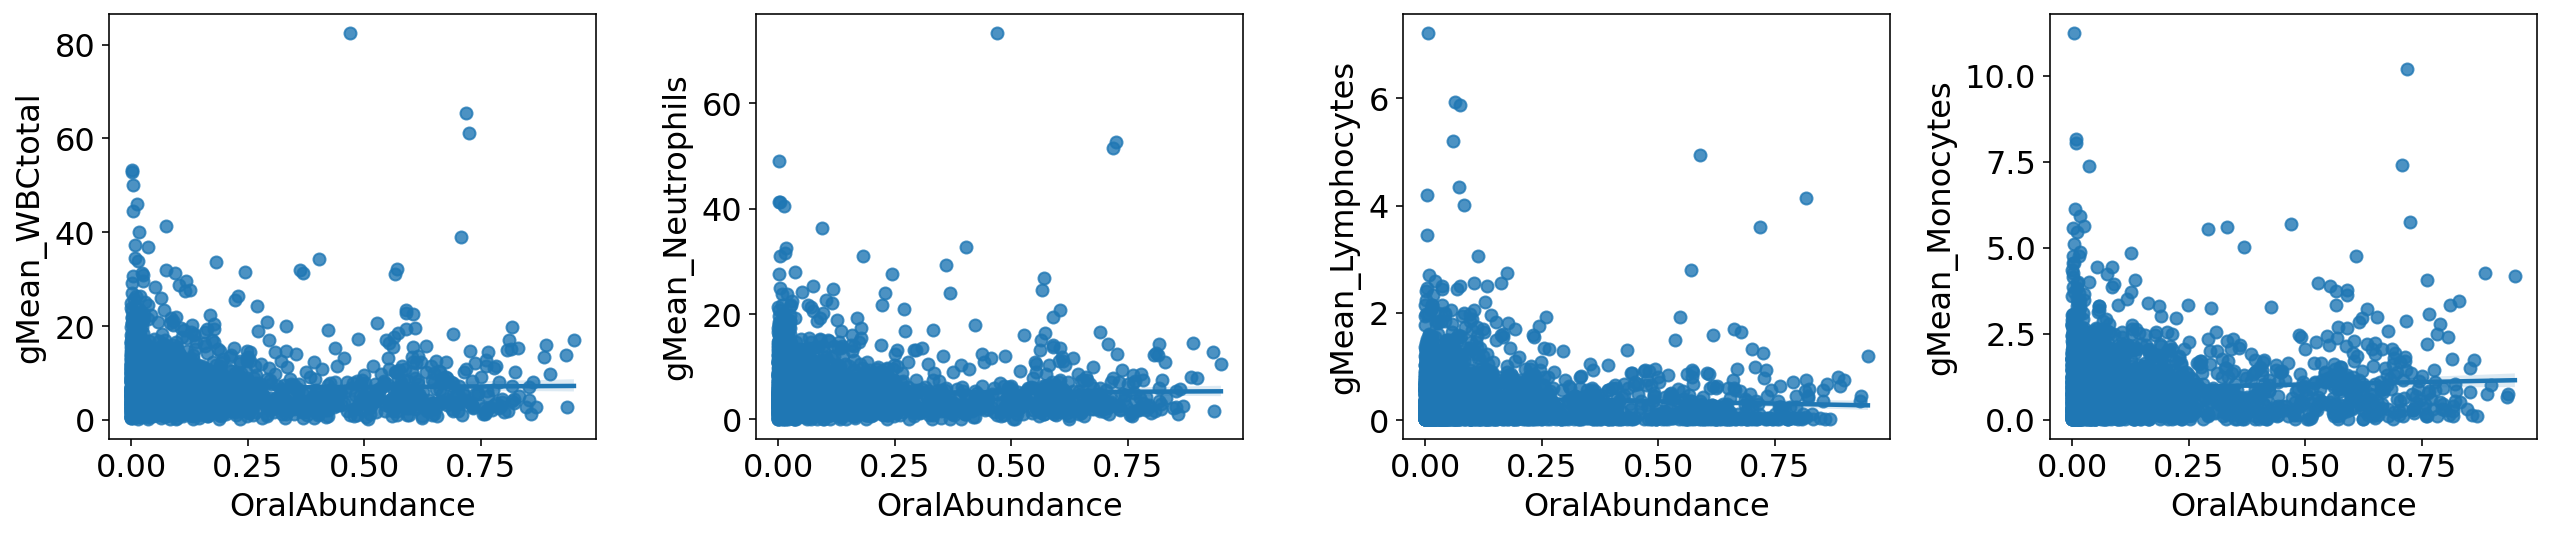

In [345]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
plt.rcParams.update({'font.size': 16})

for k,var in enumerate(['gMean_WBCtotal','gMean_Neutrophils','gMean_Lymphocytes','gMean_Monocytes']):
    _ = sns.regplot(x='OralAbundance', y=var, data=df_data, ax=ax[k])
    #_ = sns.scatterplot(x="OralAbundance", y=var, data=df_data, ax=ax[k])

#_ = ax.plot([0,2],[-1.47,-1.47],'k--')
#_ = ax.plot([0,2],[-0.52,-0.52],'k--')
#_ = ax.set_ylim([-3.5,0.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("association_oral_abundance_immunity.svg")

# Association between oral fraction and Enterococcus infection

In [27]:
# read sample info
df_sample = pd.read_csv('tblASVsamples.csv')
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read count data
df_count = pd.read_csv('tblcounts_asv_melt.csv')
df_count = pd.pivot_table(df_count, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.SampleID).intersection(set(sample_ids_w_suff_reads))]
df_relab =  df_count.div(df_count.sum(axis=1), axis=0)

# common samples between df_sample and df_relab
common_samples = set(df_sample.SampleID).intersection(df_relab.index)
df_sample = df_sample[df_sample.SampleID.isin(common_samples)]
df_relab = df_relab.loc[common_samples,:]

# get oral bacterial fraction
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relab[set(df_blast_100.query_accver).intersection(df_relab.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_relab = pd.concat([df_relab, df_oral_total], axis=1)
oral_ASVs = list(df_blast_100.query_accver)
df_oral = df_relab[set(oral_ASVs).intersection(set(df_relab.columns))].sum(axis=1)

# read infection data
df_inf = pd.read_csv('tblInfectionsCidPapers.csv')
df_inf = df_inf[df_inf.DayRelativeToNearestHCT.notnull()] # remove patients with unknown HCT day

In [28]:
def build_cox_model_input_table(infectious_agent,
                                study_start_day=-10,
                                study_stop_day=40,
                                min_samples_per_patient=2,
                                domination_threshold=0.3,
                                memory_duration=0  # note: this is the duration of a high oral state that is maintained (we assume infinite memory for low oral state)
                               ):
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue
        
        # check if the patient receives multiple HCT
        # treat each transplant as a new patient
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                assert first_sample_day < last_sample_day

            # find first infection (use timepoint to filter)
            df_inf_tmp = df_inf[(df_inf.PatientID==pid) & (df_inf.InfectiousAgent.str.contains('|'.join(infectious_agent))) & (df_inf.Timepoint>tps_from) & (df_inf.Timepoint<=tps_to)]
            df_inf_tmp = df_inf_tmp[(df_inf_tmp.DayRelativeToNearestHCT>first_sample_day) & (df_inf_tmp.DayRelativeToNearestHCT<=last_sample_day)]
            if len(df_inf_tmp) == 0:
                # no infection detected, set first infection day as the day of the last sample (censoring time)
                first_infection_day = last_sample_day
                infection_event = 0
            else:
                df_inf_tmp = df_inf_tmp.sort_values(by='DayRelativeToNearestHCT')
                first_infection_day = list(df_inf_tmp.DayRelativeToNearestHCT)[0]
                infection_event = 1
            assert first_infection_day > first_sample_day

            # use oral bacteria percentage as a covariant
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), set(oral_ASVs).intersection(set(df_relab.columns))]>domination_threshold
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) >0:
                domination_days = [int(v) for v in list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])] # days that the genus of interest dominates the sample
                nondomination_days = list(set([int(v) for v in list(df_sample_tmp.DayRelativeToNearestHCT)])-set(domination_days))
                #first_domination_day = sorted(domination_days)[0]
                curr_state = 0 
                if first_sample_day in domination_days:
                    prev_state = 1
                else:
                    prev_state = 0
                days_after_measurement = 0
                for day in np.arange(first_sample_day, first_infection_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive
                    is_dominated = int(right_day in domination_days)
                    not_dominated = int(right_day in nondomination_days)

                    # determine the current state
                    if is_dominated or not_dominated:
                        # sample was sequenced, either domination or non-domination
                        if is_dominated==1 and not_dominated==0:
                            curr_state = 1
                        elif is_dominated==0 and not_dominated==1:
                            curr_state = 0
                        else:
                            print('codes should not enter here!')
                            raise
                        days_after_measurement = 0 # reset the clock
                    else:
                        # sample was missing
                        # we only use memory to fill in missing values if previous state is dominated
                        # we assume memory is infinite if previous state is non-dominated
                        if prev_state==0:
                            curr_state=0
                        else:
                            if days_after_measurement>=memory_duration:
                                curr_state = 0
                            else:
                                curr_state = 1
                        days_after_measurement += 1

                    # add or merge a period
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.append(curr_state)
                        if right_day == first_infection_day:
                            curr_line.append(infection_event)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state)
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_infection_day:
                            last_line[-1] = infection_event
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line
            else:
                lines.append([pid, first_sample_day, first_infection_day, 0, infection_event])

    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay','Domination','Infection'])
    df_cox = df_cox.loc[:, (df_cox != 0).any(axis=0)] # remove columns that are only zero
    return df_cox

In [31]:
# build input table
df_cox_wo_mem = build_cox_model_input_table(infectious_agent='Enterococcus', memory_duration=4, min_samples_per_patient=5)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="Infection", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
Domination,0.20984,0.051548,0.854216,0.029261
